In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [49]:
df = pd.read_csv('무Model.csv')
df.index = df['날짜']
df = df.drop(['날짜'],axis=1)
scaler = MinMaxScaler()
df_mm = scaler.fit_transform(df)
df_mm = pd.DataFrame(df_mm)
df_mm.index = df.index
df_mm.columns = df.columns
df_mm.tail()


,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,무거래량,...,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가,무가격
날짜,,,,,,,,,,,,,,,,,,,,,
2020-12-25,0.000981,0.005464,0.260442,0.262181,0.261728,0.384615,0.227273,0.302326,0.296804,0.226411,...,0.222941,0.310345,0.824885,0.25,0.310345,0.528736,0.2,0.32,0.181818,0.149687
2020-12-26,0.000000,0.000000,0.285012,0.334107,0.251852,0.569231,0.348485,0.069767,0.098174,0.222846,...,0.226962,0.310345,0.824885,0.25,0.310345,0.528736,0.2,0.32,0.181818,0.154087
2020-12-28,0.000981,0.003643,0.358722,0.426914,0.350617,0.753846,0.333333,0.000000,0.038813,0.404161,...,0.234034,0.310345,0.824885,0.25,0.310345,0.528736,0.2,0.32,0.181818,0.154165
2020-12-29,0.017664,0.017955,0.307125,0.350348,0.303704,0.769231,0.469697,0.209302,0.337900,0.241270,...,0.240120,0.310345,0.824885,0.25,0.310345,0.528736,0.2,0.32,0.181818,0.169303
2020-12-30,0.010795,0.086911,0.088452,0.125290,0.120988,0.384615,0.257576,0.720930,0.509132,0.232263,...,0.245420,0.310345,0.824885,0.25,0.310345,0.528736,0.2,0.32,0.181818,0.176166


In [50]:
imsi = df_mm.drop(['무가격'],axis=1)
X = imsi.values
y = df_mm['무가격'].values


In [51]:
def seq_data(x, y, sequence_length):
  
  x_seq = []
  y_seq = []
  for i in range(len(x) - sequence_length):
    x_seq.append(x[i: i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1]) # float형 tensor로 변형, gpu사용가능하게 .to(device)를 사용.
  

In [52]:
split = 200
sequence_length = 2000

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]
print(x_train_seq.size(), y_train_seq.size())
print(x_test_seq.size(), y_test_seq.size())

torch.Size([169, 2000, 26]) torch.Size([169, 1])
torch.Size([0, 2000, 26]) torch.Size([0, 1])


In [53]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

In [54]:
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

In [55]:
class VanillaRNN(nn.Module):

  def __init__(self, input_size, hidden_size, sequence_length, num_layers, device):
    super(VanillaRNN, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
    self.fc = nn.Sequential(nn.Linear(hidden_size * sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size()[0], self.hidden_size).to(self.device) # 초기 hidden state 설정하기.
    out, _ = self.rnn(x, h0) 
    out = out.reshape(out.shape[0], -1) 
    out = self.fc(out)
    return out
model = VanillaRNN(input_size=input_size,
                   hidden_size=hidden_size,
                   sequence_length=sequence_length,
                   num_layers=num_layers,
                   device=device).to(device)

In [56]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(), lr=lr)

In [57]:
loss_graph = [] # 그래프 그릴 목적인 loss.
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:

    seq, target = data # 배치 데이터.
    out = model(seq)   # 모델에 넣고,
    loss = criterion(out, target) # output 가지고 loss 구하고,

    optimizer.zero_grad() # 
    loss.backward() # loss가 최소가 되게하는 
    optimizer.step() # 가중치 업데이트 해주고,
    running_loss += loss.item() # 한 배치의 loss 더해주고,

  loss_graph.append(running_loss / n) # 한 epoch에 모든 배치들에 대한 평균 loss 리스트에 담고,
  if epoch % 100 == 0:
    print('[epoch: %d] loss: %.4f'%(epoch, running_loss/n))

[epoch: 0] loss: 0.0667
[epoch: 100] loss: 0.0568


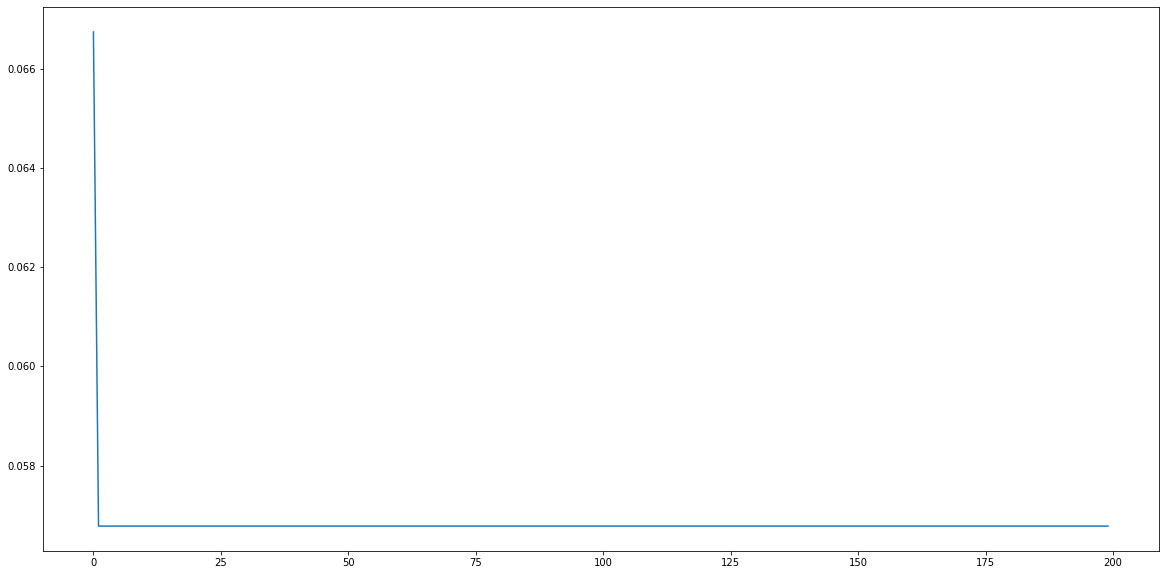

In [58]:
plt.figure(figsize=(20,10))
plt.plot(loss_graph)
plt.show()

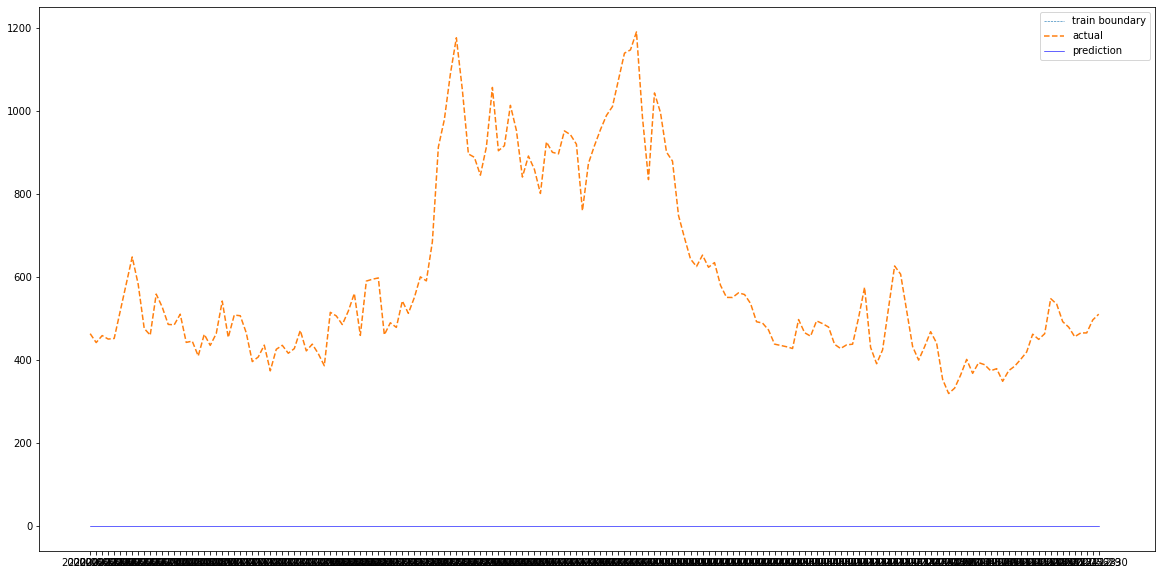

In [61]:
def plotting(train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()
      
  total = train_pred + test_pred
  plt.figure(figsize=(20,10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth=0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train boundary', 'actual', 'prediction'])
  plt.show()

plotting(train_loader, test_loader, df['무가격'][sequence_length:])